In [61]:
import os
import pandas as pd
from matplotlib import pyplot as plt
from yaml import Loader, FullLoader, load

%matplotlib inline

In [8]:
base_dir = os.path.dirname(os.getcwd())
result_dir = os.path.join(base_dir, 'results')

## Settings

Please adjust the following settings depending on what you want to plot. 

`experiment` refers to the experiment name given to the training run that you would like to inspect. 

`subdir` refers to the directory to which the evaluation metrics have been written to. If you've specified the `experiment_type` when running `evaluate_performance.py`, `subdir` should be set to the same name, otherwise it should be set to `{model}_only`, where `model` is replaced by the name of the model you've been using.

`metric` can be set to one of the following evaluation metrics:
- `rmse` (root mean squared error), 
- `pcc` (Pearson correlation coefficient)
- `mae` (mean absolute error).

In [32]:
datasource = 'radar'
model = 'FluxRGNN'
test_year = '2017'
experiment = 'final'
subdir = 'final'
metric = 'rmse'

## Load config file

In [34]:
cfg_path = os.path.join(result_dir, datasource, model, f'test_{test_year}', 
                   experiment, 'trial_1', 'config.yaml')
with open(cfg_path) as f:
    config = load(f, Loader=FullLoader)

## Plot predictive performance
Note that here the RMSE is plotted in terms of $\textrm{birds/km}^2$, and not in terms of rescaled quanities (between 0 and 1) as it is done in our paper. 

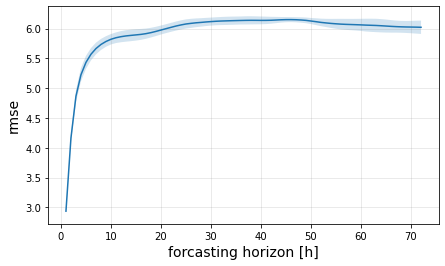

In [63]:
eval_path = os.path.join(result_dir, datasource, 'performance_evaluation', subdir)
df = pd.read_csv(os.path.join(eval_path, f'{metric}_per_hour.csv'))
df = df.query(f'horizon > 0 & horizon <= 72 & model == "{model}" & experiment == "{experiment}"')
    
grouped = df.groupby('horizon')        
avg = grouped[metric].aggregate(np.nanmean).values
std = grouped[metric].aggregate(np.nanstd).values

fig, ax = plt.subplots(figsize=(7, 4))
ax.plot(df.horizon.unique(), avg)
ax.fill_between(df.horizon.unique(), avg-std, avg+std, alpha=0.2)
ax.set_ylabel(metric, fontsize=14)
ax.set_xlabel('forcasting horizon [h]', fontsize=14)
ax.grid(color = 'gray', linestyle = '-', alpha=0.2)

## Plot example prediction

### Load results from disk

In [36]:
results = []
for t in range(1, config['task']['repeats']+1):
    file = os.path.join(result_dir, datasource, model, f'test_{test_year}', 
                        experiment, f'trial_{t}', 'results_fixedT0.csv')

    if os.path.isfile(file):
        df = pd.read_csv(file)
        df['trial'] = t
        results.append(df)

results = pd.concat(results)

### Plotting
Please specify the `radar` for which you would like to plot a prediction. 
The `trial` specifies which of the model instances (trained with the same settings but different random seeds) you would like to inspect. `seqID` is the ID of the sequence that is plotted. You can have a look at `results_fixedT0.csv` to find a sequence starting at a specific time point.

In [64]:
radar = 'dehnr'
trial = 2
seqID = 13

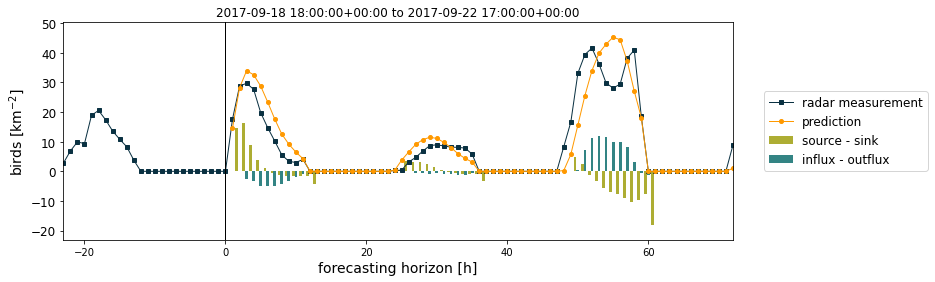

In [71]:
df = results.query(f'radar == "{radar}" & seqID == {seqID} & trial == {trial}').copy()

fig, ax = plt.subplots(figsize=(12, 4))

ax.plot(df.horizon.values, df.gt_km2.values, marker='s', ms=4, linewidth=1, 
           color='#0a3142', label='radar measurement')
ax.plot(df.horizon.values, df.prediction_km2.values, marker='o', ms=4, linewidth=1, 
           color='#ff9900', label='prediction')
ax.axvline(0, lw=1, color='k')

if model == 'FluxRGNN':
    df['source_sink'] = df.apply(lambda row: row.source_km2 - row.sink_km2, axis=1)
    df['net_flux'] = df.apply(lambda row: row.influx_km2 - row.outflux_km2, axis=1)

    maxy = max(df['gt_km2'].max(), df['prediction_km2'].max()) + 5
    miny = min(df['source_sink'].min(), df['net_flux'].min()) - 5

    xrange = np.arange(df.horizon.min(), df.horizon.max()+1)
    ax.bar(xrange+0.6, df.source_sink.values, width=0.4, alpha=0.8, 
              label='source - sink', color='#999900', edgecolor=None)
    ax.bar(xrange+1, -df.net_flux.values, width=0.4, alpha=0.8, 
              label='influx - outflux', color='#006666')
    
ax.set_title(f'{df.datetime.values[0]} to {df.datetime.values[-1]}')
ax.set_ylabel(r'birds [km$^{-2}$]', fontsize=14)
ax.set_xlabel('forecasting horizon [h]', fontsize=14)
ax.set(ylim=(miny, maxy), xlim=(xrange[0], xrange[-1]))
ax.tick_params(axis='y', which='major', labelsize=12)
ax.legend(loc='center right', fontsize=12, bbox_to_anchor=(1.3, 0.5));